<h3> SENSITIVITY ANALYSIS</h3>
In this JNB, we explore the effect of changing the threshold paramters  $\delta$ and $\tau$ on the linkage ratio $\lambda(\delta,\tau)$.  In particular, we plot level curves for the peak months of activity (May-Aug).

1) Import Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

2) Specify the Police District

In [2]:
district=3.0

3) Import the Chicago shotspotter data and filter for the specified district.

In [3]:
shot_data_raw = pd.read_csv('Shotspotter_data.csv')
shot_data_raw=shot_data_raw[shot_data_raw["DISTRICT"]==district]
for i in shot_data_raw.index:
    x=shot_data_raw.loc[i,"DATE"]
    x1=x.split(' ')
    x2=x1[0].split('/')
    shot_data_raw.loc[i,"time"]=x1[1]
    shot_data_raw.loc[i,'MONTH'] =int(x2[0])
    shot_data_raw.loc[i,"day"]=x2[1]
    shot_data_raw.loc[i,"YEAR"]=int(x2[2])
shot_data_raw=shot_data_raw.reset_index(drop=True)
shot_data_raw.head(5)

,DATE,BLOCK,ZIP_CODE,WARD,COMMUNITY_AREA,AREA,DISTRICT,BEAT,STREET_OUTREACH_ORGANIZATION,UNIQUE_ID,...,INCIDENT_TYPE_DESCRIPTION,ROUNDS,ILLINOIS_HOUSE_DISTRICT,ILLINOIS_SENATE_DISTRICT,LATITUDE,LONGITUDE,LOCATION,time,day,YEAR
0,1/29/2018 15:27,NaN,60637.0,20.0,GREATER GRAND CROSSING,1.0,3.0,322.0,Acclivus Greater Grand Crossing,SST-1628,...,SINGLE GUNSHOT,1,32.0,16.0,41.772790,-87.618193,POINT (-87.61819334612 41.772790345858),15:27,29,2018.0
1,1/30/2018 18:43,7000 S STONY ISLAND,60649.0,5.0,SOUTH SHORE,1.0,3.0,332.0,Claretian Associates South Shore,SST-1662,...,SINGLE GUNSHOT,1,26.0,13.0,41.766797,-87.585398,POINT (-87.58539765388 41.766797345858),18:43,30,2018.0
2,1/31/2018 1:45,NaN,60649.0,5.0,SOUTH SHORE,1.0,3.0,332.0,Claretian Associates South Shore,SST-1670,...,GUNSHOT OR FIRECRACKER,1,25.0,13.0,41.773760,-87.581308,POINT (-87.581307547471 41.773759668947),1:45,31,2018.0
3,2/1/2018 17:51,NaN,60637.0,20.0,WOODLAWN,1.0,3.0,312.0,Project H.O.O.D. Woodlawn,SST-1715,...,GUNSHOT OR FIRECRACKER,12,5.0,3.0,41.778602,-87.609718,POINT (-87.609718 41.7786015),17:51,1,2018.0
4,2/1/2018 19:29,6600 S LANGLEY AVE,60637.0,20.0,WOODLAWN,1.0,3.0,321.0,None,SST-1720,...,MULTIPLE GUNSHOTS,7,5.0,3.0,41.773794,-87.608251,POINT (-87.608250547471 41.773793668947),19:29,1,2018.0


3) Streamline the dataframe.

In [4]:
shot_data_raw=shot_data_raw[["DATE","YEAR","MONTH","LATITUDE","LONGITUDE","LOCATION"]]
shot_data_raw.head(5)

,DATE,YEAR,MONTH,LATITUDE,LONGITUDE,LOCATION
0,1/29/2018 15:27,2018.0,1,41.772790,-87.618193,POINT (-87.61819334612 41.772790345858)
1,1/30/2018 18:43,2018.0,1,41.766797,-87.585398,POINT (-87.58539765388 41.766797345858)
2,1/31/2018 1:45,2018.0,1,41.773760,-87.581308,POINT (-87.581307547471 41.773759668947)
3,2/1/2018 17:51,2018.0,2,41.778602,-87.609718,POINT (-87.609718 41.7786015)
4,2/1/2018 19:29,2018.0,2,41.773794,-87.608251,POINT (-87.608250547471 41.773793668947)


5) Read in the shooting event data.

In [7]:
hom_data_raw = pd.read_csv('Shooting_data.csv')
for i in hom_data_raw.index:
    x=hom_data_raw.loc[i,"Date"]
    x1=x.split(' ')
    x2=x1[0].split('/')
    hom_data_raw.loc[i,'MONTH'] =int(x2[0])
hom_data_raw.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'MONTH'],
      dtype='object')

6) Filter the shooting data for D3 and create a column "spotted" to indicate which events are linked to shotspotter incidents (note that there might be several linked shooting and shotspotter incidents based on the threshold values).

In [8]:
hom_data_raw= hom_data_raw[['Date','Year','MONTH','District','Latitude', 'Longitude','Location']]
hom_data_raw= hom_data_raw[hom_data_raw['District'] == int(district)]
hom_data_raw= hom_data_raw.reset_index(drop=True)
hom_data_raw['spotted'] = 0
hom_data_raw.columns=["DATE","YEAR","MONTH","DISTRICT","LATITUDE","LONGITUDE","LOCATION","spotted"]
hom_data_raw.head(2)

,DATE,YEAR,MONTH,DISTRICT,LATITUDE,LONGITUDE,LOCATION,spotted
0,1/2/2018 14:55,2018,1.0,3,41.777465,-87.617264,"(41.777464689, -87.617264087)",0
1,1/6/2018 11:12,2018,1.0,3,41.769885,-87.568652,"(41.769884528, -87.568652033)",0


7) Import libraries used to link positions and times of shotspotter and shooting incidents.

In [10]:
!!pip install geopy
from geopy import distance
import datetime
import re

8) Create variables 'strdate1' and 'strdate2' with date and time information for the 3rd shooting and 1st shot spotter incidents.

In [11]:
pt1 = [hom_data_raw.loc[3,"LATITUDE"],hom_data_raw.loc[3,"LONGITUDE"]]
pt2 = [shot_data_raw.loc[1,"LATITUDE"],shot_data_raw.loc[1,"LONGITUDE"]]
print("Distance between events is ", distance.distance(pt1, pt2).km, ' km')
strdate1 = hom_data_raw.loc[3,"DATE"]
strdate2 = shot_data_raw.loc[1,"DATE"]
date1 = datetime.datetime.strptime(strdate1, "%m/%d/%Y %H:%M")
date2 = datetime.datetime.strptime(strdate2, "%m/%d/%Y %H:%M")
dt = date1-date2
print(date1)
print(date2)
print("Time between events is ", int(dt.total_seconds()/60))

Distance between events is  3.2000326883527346  km
2018-02-02 00:04:00
2018-01-30 18:43:00
Time between events is  3201


<h3>Problem</h3>
Plot level curves which show the linkage ratio $\lambda(\delta,\tau)$ for $0\le \delta=.3$ km and $0\le \tau \le$ 30 minutes.


a) Function to process data and get linking distribution for a specified year and month

In [12]:
def LD(hom_data,shot_data,year,month,delta,tau):
    #install libraries
    from geopy import distance
    import datetime
    #get the threshold values
    delta = delta
    tau = tau
    hom_data = hom_data[hom_data["YEAR"]==year]
    shot_data = shot_data[shot_data["YEAR"]==year]
    hom_data = hom_data[hom_data["MONTH"]==month]
    shot_data = shot_data[shot_data["MONTH"]==month]
    shot_data = shot_data.reset_index(drop = True)
    hom_data = hom_data.reset_index(drop=True)
    #define the function to determine linkage of shotspotter and shooting incidents based on the threshold values
    def linked(P, T, delta, tau):
        for k in range(P.shape[0]):
            for q in range(P.shape[1]):
                if P[k][q] < delta and T[k][q] < tau and T[k][q] >= 0:
                    hom_data.loc[k, 'spotted'] = hom_data.loc[k,'spotted']+ 1
    #Create the P and T matrices
    P = np.zeros((hom_data.shape[0], shot_data.shape[0]))
    T = np.zeros((hom_data.shape[0], shot_data.shape[0]))
    for i in hom_data.index:
        for j in shot_data.index:
            location1 = hom_data.loc[i,"LOCATION"]
            location2 = shot_data.loc[j,"LOCATION"]
            a1 = location1.split(' ')
            a2 = location2.split(' ')
            #pt1 = [float(re.sub('[^0-9.-]','', a1[2])),float(re.sub('[^0-9.-]','', a1[1]))]
            #pt2 = [float(re.sub('[^0-9.-]','', a2[2])),float(re.sub('[^0-9.-]','', a2[1]))]
            pt1 = [hom_data.loc[i,"LATITUDE"],hom_data.loc[i,"LONGITUDE"]]
            pt2 = [shot_data.loc[j,"LATITUDE"],shot_data.loc[j,"LONGITUDE"]]
            P[i][j] = distance.distance(pt1, pt2).km
            strdate1 = hom_data.loc[i,"DATE"]
            strdate2 = shot_data.loc[j,"DATE"]
            date1 = datetime.datetime.strptime(strdate1, "%m/%d/%Y %H:%M")
            date2 = datetime.datetime.strptime(strdate2, "%m/%d/%Y %H:%M")
            dt = date1-date2
            T[i][j] = int(dt.total_seconds() / 60)
    #Apply the function linked to the P and T matrices
    linked(P,T,delta,tau)
    #return the linking distribution
    return hom_data['spotted'].value_counts()

b) Function to get for a specified year the monthly linkage ratio, total number of shooting incidents, and number of linked shooting incidents

In [13]:
def linkageratio(year,delta,tau,hom_data_raw,shot_data_raw):
    tot= [[]] * 12
    linked = [[]] * 12
    ratio = [[]]*12
    L = [[]]*12
    for mo in np.arange(0,12,1):
        L[mo]=LD(hom_data_raw,shot_data_raw,year,mo+1,delta,tau)
        tot[mo] = np.sum(L[mo])
        if 0 in L[mo].index:
            linked[mo] = tot[mo]-L[mo][0]
        else:
            linked[mo] = tot[mo]
        ratio[mo] = linked[mo]/tot[mo]
    return [ratio,linked,tot]

In [14]:
#use to store specified year linkage ratios. linked shooting incidents, and total shooting incidents
yrtot= [[]] * 4
yrlinked=[[]]*4
yrratio=[[]]*4

c) Define a function $LR(\delta,\tau)$ which determines the linkage ratio for a specified year as a funcion of the threshold values $\delta$ and $\tau$.

In [18]:
def LR(year,delta,tau,hom_data_raw,shot_data_raw):
    [yrratio[0],yrlinked[0],yrtot[0]]=linkageratio(2018,delta,tau,hom_data_raw,shot_data_raw) #year 0 =2018
    return yrratio[0]

d) Make level curves for $LR(\delta,\tau)$

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pylab

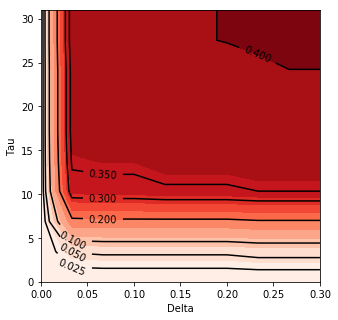

In [42]:
import numpy as np
from matplotlib import rcParams
# Initialize plot objects
rcParams['figure.figsize'] = 5, 5 # sets plot size
fig = plt.figure()
ax = fig.add_subplot(111)

# Define levels in z-axis where we want lines to appear
levels = np.array([0,.025,.05,.1,.2,.3,.35,.4,.45,.5])

N=10
M=10

# List of points in x axis
DeltaPoints     = []

# List of points in y axis
TauPoints     = []

# Delta points are from 0 to .3 divided evenly into N testpoints
for val in np.linspace(0, .3, N):
    DeltaPoints.append(val)
    
# Tau points are from 0 to 30 divided evenly into M testpoints
for val in np.linspace(0, 31, M):
    TauPoints.append(val)
    
X, Y = np.meshgrid(DeltaPoints,TauPoints)
    
# Populate L(delta,tau) for year=2020
year=2020

L     = np.ndarray((N,M))

for d in np.arange(0,N,1):
    for t in np.arange(0,M,1):
           L[d][t] = np.sum(LR(year,DeltaPoints[d],TauPoints[t],hom_data_raw,shot_data_raw))/12

# Generate a color mapping of the levels we've specified
import matplotlib.cm as cm # matplotlib's color map library
cpf = ax.contourf(X,Y,L, len(levels), cmap=cm.Reds)

# Set all level lines to black
line_colors = ['black' for l in cpf.levels]

# Make plot and customize axes
cp = ax.contour(X, Y, L, levels=levels, colors=line_colors)
ax.clabel(cp, fontsize=10, colors=line_colors)
plt.xticks(np.arange(0,.35,.05))
plt.yticks(np.arange(0,35,5))
ax.set_xlabel('Delta')
_ = ax.set_ylabel('Tau')
plt.savefig('sensitivity.png') # uncomment to save vector/high-res version
plt.show()